In [34]:
import pandas as pd
from urllib.request import urlopen
import json
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

### Get historical data from the NASA POWER PROJECT API
##### Data is collected from: 1st Jan 2012 through 19th March 2022

In [35]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point?start=20120101&end=20220319&latitude=-1.5177&longitude=37.2634&parameters=T2M,PS,WS10M,QV2M,PRECTOTCORR&community=AG&format=csv"

csv_path = keras.utils.get_file(fname="machakos-county-2012-2022.csv", origin=url)

147456/135031 [================================] - 1s 6us/step


In [36]:
def parse_date(x):
    return datetime.strptime(x, '%Y %j')

In [37]:
# Skip the CSV description rows
df = pd.read_csv(csv_path, skiprows=13, parse_dates={'date': ['YEAR', 'DOY']}, date_parser=parse_date, skipinitialspace=True, index_col=0)

In [38]:
df['T2M']

date
2012-01-01     19.01
2012-01-02     19.31
2012-01-03     20.82
2012-01-04     21.26
2012-01-05     21.69
               ...  
2022-03-15     23.58
2022-03-16     24.25
2022-03-17     23.58
2022-03-18   -999.00
2022-03-19   -999.00
Name: T2M, Length: 3731, dtype: float64

In [39]:
# Get column names
df.columns

Index(['T2M', 'PS', 'WS10M', 'QV2M', 'PRECTOTCORR'], dtype='object')

In [40]:
titles = ["Temperature at 2 Meters (C)", "Surface Pressure (kPa)", "Wind Speed at 10 Meters (m/s)", "Precipitation Corrected (mm/day)"]
feature_keys = ["T2M", "PS", "WS10M", "PRECTOTCORR"]
date_time_key = ["date"]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

In [41]:
# Remove empty values
indexes_to_drop = df.index[df['T2M'] == -999.00]
df.drop(indexes_to_drop, inplace=True)

In [42]:
df.columns

Index(['T2M', 'PS', 'WS10M', 'QV2M', 'PRECTOTCORR'], dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3729 entries, 2012-01-01 to 2022-03-17
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T2M          3729 non-null   float64
 1   PS           3729 non-null   float64
 2   WS10M        3729 non-null   float64
 3   QV2M         3729 non-null   float64
 4   PRECTOTCORR  3729 non-null   float64
dtypes: float64(5)
memory usage: 174.8 KB


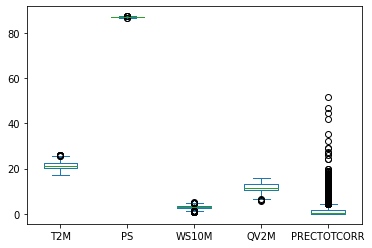

In [44]:
# Box plot
df.plot.box()

plt.savefig("Box plot", dpi=1200)


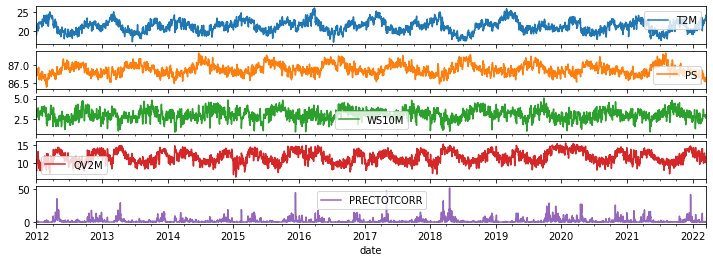

In [45]:
# Visualize trends
df.plot.line(figsize=(12, 4), subplots=True)
plt.savefig("Sub plot", dpi=1200)

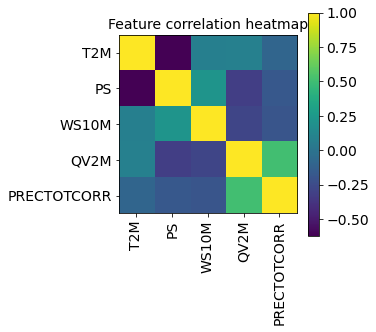

In [46]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature correlation heatmap", fontsize=14)
    plt.show()

show_heatmap(df)

In [47]:
correlation = df.corr()
print(correlation['PRECTOTCORR'].sort_values(ascending = False),'\n')

PRECTOTCORR    1.000000
QV2M           0.509150
T2M           -0.094317
PS            -0.172992
WS10M         -0.189735
Name: PRECTOTCORR, dtype: float64 



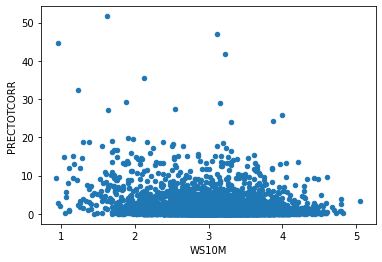

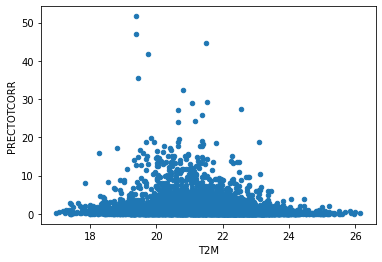

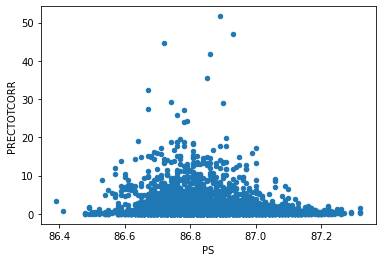

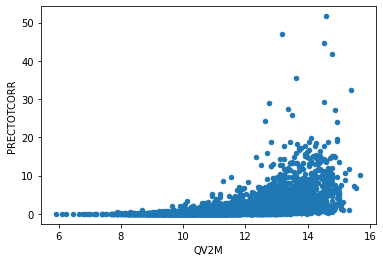

In [48]:
for i in ['WS10M', 'T2M', 'PS', 'QV2M']:
    df.plot.scatter(x=i, y='PRECTOTCORR')

In [49]:
# Drop PS columns as it is multicorrelated to the T2M column
df.drop(['PS'], axis=1, inplace=True)

In [50]:
df.head()

,T2M,WS10M,QV2M,PRECTOTCORR
date,,,,
2012-01-01,19.01,3.63,7.81,0.00
2012-01-02,19.31,3.31,7.69,0.00
2012-01-03,20.82,2.73,9.16,0.00
2012-01-04,21.26,2.77,9.70,0.00
2012-01-05,21.69,2.80,9.89,0.25


In [51]:
# LSTM uses sigmooid and tanh which is sensitive to magnitude hence must be standardized 
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df)

In [62]:


# Split data into training and validation

# Tranform from timeseries to supervised
x_val = df_train_scaled[:,0:3]
y_val = df_train_scaled[:,-1]
n_future = 1
n_past = 14

trainX, trainY = [], []

for i in range(n_past, len(df_train_scaled) - n_future + 1):
    trainX.append(df_train_scaled[i - n_past:i, 0:df_train_scaled.shape[1]])
    trainY.append(df_train_scaled[i + n_future - 1 : i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

In [63]:
print('trainX.shape == {}'.format(trainX.shape))
print('trainY.shape == {}'.format(trainY.shape))

trainX.shape == (3715, 14, 4)
trainY.shape == (3715, 1)


In [64]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2022-03-21 16:13:40.447872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-21 16:13:40.447967: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-21 16:13:40.448001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-P0V5CL4): /proc/driver/nvidia/version does not exist
2022-03-21 16:13:40.449432: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
209/209 [==============================] - 9s 34ms/step - loss: 0.8418 - val_loss: 0.8302
Epoch 2/5
209/209 [==============================] - 6s 31ms/step - loss: 0.7701 - val_loss: 0.7848
Epoch 3/5
209/209 [==============================] - 7s 32ms/step - loss: 0.7204 - val_loss: 0.7632
Epoch 4/5
209/209 [==============================] - 7s 32ms/step - loss: 0.6800 - val_loss: 0.7482
Epoch 5/5
209/209 [==============================] - 7s 33ms/step - loss: 0.6499 - val_loss: 0.7409


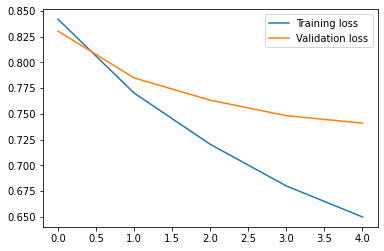

In [65]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()